# Downloading, pre-processing and running cNMF on marjanovic et. al 2020 data
1. Obtaining the data and creating AnnData object
2. filtering genes and selecting joint highly variable genes (HVGs) and showing key statistics
3. Splitting the dataset by timepoints, and selecting HVG per timepoint
3. Running consensus NMF (cNMF) per timepoint
4. Selecting parameters for the cNMF 


In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
from importlib import reload

import sys
import os
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf

print(os.getcwd())
# os.chdir('/cs/labs/mornitzan/yotamcon/gep-dynamics')

/cs/labs/mornitzan/yotamcon/gep-dynamics/notebooks
CPU times: user 1.56 s, sys: 709 ms, total: 2.27 s
Wall time: 29.4 s


### Downloading or loading AnnData object

In [2]:
%%time
results_dir = _utils.set_dir('results')
orig_adata_path = results_dir.joinpath('marjanovic_mmLungPlate.h5ad')

if not orig_adata_path.exists():  # create the original adata if it doesn't exist
    # directories for file download:
    data_dir = _utils.set_dir('data')
    GSE_dir = _utils.set_dir(data_dir.joinpath('GSE154989'))
    
    # GEO server prefix for mmLungPlate SubSeries GSE154989
    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE154nnn/GSE154989/suppl/'

    #filenames
    f_rawCount = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_dSp_rawCountOrig.h5')
    f_geneTable = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_geneTable.csv.gz')
    f_smpTable = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_smpTable.csv.gz')
    f_smp_annot = GSE_dir.joinpath('GSE154989_mmLungPlate_fQC_dZ_annot_smpTable.csv.gz')

    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE154nnn/GSE154989/suppl/'

    # downloading if needed:
    if not f_rawCount.exists():
        urlretrieve(ftp_address + f_rawCount.name, f_rawCount)
    
    if not f_geneTable.exists():
        urlretrieve(ftp_address + f_geneTable.name, f_geneTable)
    
    if not f_smpTable.exists():
        urlretrieve(ftp_address + f_smpTable.name, f_smpTable)
    
    if not f_smp_annot.exists():
        urlretrieve(ftp_address + f_smp_annot.name, f_smp_annot)
    
    # reading the files
    sparse_counts = _utils.read_matlab_h5_sparse(f_rawCount)
    
    gene_ids = pd.read_csv(f_geneTable, index_col=0)
    smp_ids = pd.read_csv(f_smpTable, index_col=0)
    smp_annotation = pd.read_csv(f_smp_annot, index_col=0)
    
    # constructing the adata
    adata = sc.AnnData(X=sparse_counts, dtype=np.float32, var=gene_ids, obs=smp_ids)
    
    adata.obs['clusterK12'] = smp_annotation.clusterK12.astype('category')
    
    adata.obsm['X_tsne'] = smp_annotation[['tSNE_1', 'tSNE_2']].values
    adata.obsm['X_phate'] = smp_annotation[['phate_1', 'phate_2']].values
    adata.write(orig_adata_path)
else:
    adata = sc.read(orig_adata_path)

adata
# adata_norm_depth = sc.read(data_dir.joinpath('marjanovic_mmLungPlate_depth_normalized.h5ad'))



CPU times: user 88 ms, sys: 127 ms, total: 215 ms
Wall time: 7.37 s


AnnData object with n_obs × n_vars = 3891 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'timesimple_colors'
    obsm: 'X_phate', 'X_tsne'

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


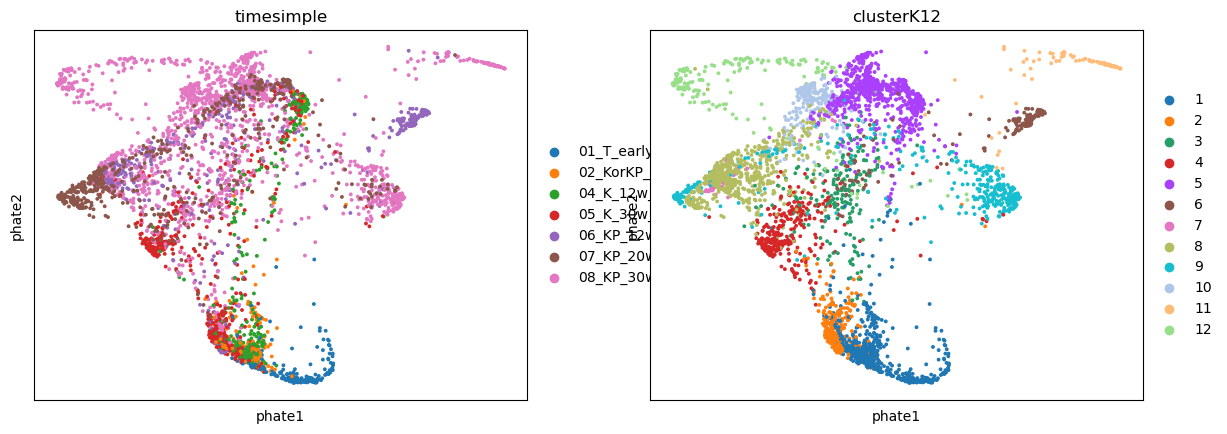

In [60]:
sc.external.pl.phate(adata, color=['timesimple', 'clusterK12'])
adata.uns['timesimple_colors_dict'] = dict(zip(adata.obs['timesimple'].cat.categories, adata.uns['timesimple_colors']))
adata.uns['clusterK12_colors_dict'] = dict(zip(adata.obs['clusterK12'].cat.categories, adata.uns['clusterK12_colors']))

In [4]:
pd.crosstab(adata.obs.timesimple, adata.obs.clusterK12)

clusterK12,1,2,3,4,5,6,7,8,9,10,11,12
timesimple,,,,,,,,,,,,
01_T_early_ND,202,4,0,0,0,0,0,0,0,0,0,0
02_KorKP_early_ND,93,35,7,0,7,0,0,0,0,0,0,0
04_K_12w_ND,240,54,34,8,117,0,0,1,1,0,0,0
05_K_30w_ND,82,133,32,163,71,0,1,15,8,0,0,0
06_KP_12w_ND,4,40,34,17,108,109,8,142,18,9,2,0
07_KP_20w_ND,6,2,13,48,119,10,16,189,134,0,1,0
08_KP_30w_ND,25,17,73,79,343,39,11,270,214,208,86,189


### Filter genes and plot basic statistics

In [5]:
# # filtering genes with very low abundance
# sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 1000))
# sc.pp.filter_genes(adata, min_counts=40)
#
# # getting general statistics for counts abundance
# sc.pp.filter_cells(adata, min_counts=0)
# sc.pp.filter_cells(adata, min_genes=0)
#
# sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)
# adata

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 3891 × 30999
    obs: 'plateID', 'mouseID', 'timesimple', 'typeID', 'clusterK12', 'n_counts', 'n_genes'
    var: 'ensgID', 'geneSymbol', 'length', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'timesimple_colors', 'clusterK12_colors'
    obsm: 'X_phate', 'X_tsne'

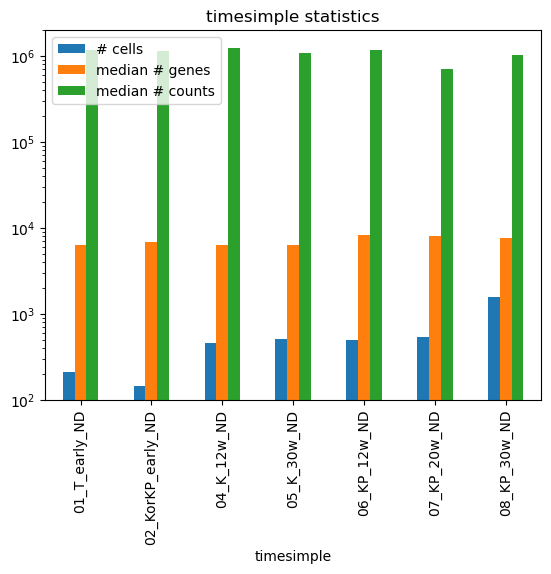

In [6]:
column_of_interest = 'timesimple'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((1e2, 2e6)))
plt.show()
del column_of_interest, stats_df

### Splitting the adata by "timesimple", and creating a normalized variance layer

In [7]:
%%time

times = adata.obs.timesimple.cat.categories
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

for time in times:
    if not split_adatas_dir.joinpath(f'{time}.h5ad').exists():
        tmp = adata[adata.obs.timesimple == time].copy()

        tmp.uns['name'] = f'{time}'   # full name
        tmp.uns['sname'] = f't{time[:2]}'  # short name

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        # calculating per sample HVGs
        sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{time}.h5ad'))

        del tmp

CPU times: user 156 µs, sys: 61 µs, total: 217 µs
Wall time: 197 µs


### Running multiple NMF iterations

In [13]:
%%time

cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

for time in times:
    print(f'Starting on {time}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{time}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, time)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.highly_variable].toarray(), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=200, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on 01_T_early_ND
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Starting on 02_KorKP_early_ND
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Starting on 04_K_12w_ND
Combining factorizations f

In [14]:
for time in times:
    print(f'Starting on {time}')
    c_object = cnmf.cNMF(cnmf_dir, time)
    for thresh in [0.5, 0.4, 0.3]:
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=500,
                                  close_fig=True, show_clustering=True)

Starting on 01_T_early_ND
Failed consensus for k=7 due to <class 'ValueError'>.
Number of labels is 7. Valid values are 2 to n_samples - 1 (inclusive)
Failed consensus for k=8 due to <class 'ValueError'>.
Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 1 is required by KMeans.
Failed consensus for k=9 due to <class 'ValueError'>.
Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 1 is required by KMeans.
Failed consensus for k=10 due to <class 'ValueError'>.
Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 1 is required by KMeans.
Failed consensus for k=11 due to <class 'ValueError'>.
Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 1 is required by KMeans.
Failed consensus for k=12 due to <class 'ValueError'>.
Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 1 is required by KMeans.
Failed consensus for k=13 due to <class 'ValueError'>.
Found array with 0 sample(s) (shape=(0, 2000)) while a minimum of 

### Selecting the decomposition rank utilizing K-selection plots and PCA variance explained

In [543]:
n_components = 14

for time in times:
    
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{time}.h5ad'))
    
    a, b, c, d, = sc.tl.pca(tmp.X[:, tmp.var.highly_variable], n_comps=n_components, return_info=True)
    print(f'{time} - cummulative variance percentages:'),
    for i in range(n_components):
        print(f'{c[i]*100: .2f}', end='\t')
    print()
    for i in range(n_components):
        print(f'{c.cumsum()[i]*100: .2f}', end='\t')
    print()

01_T_early_ND - cummulative variance percentages:
 84.73	 7.99	 1.21	 0.82	 0.76	 0.60	 0.54	 0.43	 0.28	 0.23	 0.20	 0.17	 0.14	 0.13	
 84.73	 92.72	 93.93	 94.75	 95.51	 96.11	 96.65	 97.08	 97.36	 97.59	 97.79	 97.96	 98.10	 98.23	
02_KorKP_early_ND - cummulative variance percentages:
 63.75	 18.12	 6.03	 2.70	 2.63	 1.28	 0.88	 0.62	 0.41	 0.38	 0.32	 0.26	 0.23	 0.17	
 63.75	 81.87	 87.90	 90.60	 93.23	 94.51	 95.39	 96.01	 96.42	 96.81	 97.13	 97.38	 97.61	 97.78	
04_K_12w_ND - cummulative variance percentages:
 48.04	 27.67	 5.81	 3.17	 2.80	 1.81	 1.64	 1.05	 1.00	 0.77	 0.69	 0.47	 0.36	 0.31	
 48.04	 75.71	 81.52	 84.70	 87.50	 89.31	 90.95	 91.99	 92.99	 93.76	 94.44	 94.92	 95.28	 95.59	
05_K_30w_ND - cummulative variance percentages:
 38.38	 36.16	 11.30	 4.21	 2.43	 1.86	 1.24	 0.63	 0.36	 0.33	 0.25	 0.22	 0.17	 0.15	
 38.38	 74.54	 85.83	 90.04	 92.47	 94.33	 95.57	 96.20	 96.56	 96.90	 97.15	 97.37	 97.54	 97.70	
06_KP_12w_ND - cummulative variance percentages:
 36.88	

In [544]:
# %%time

# selected_cnmf_params = {
#     '01_T_early_ND': (2, 0.5),  # rank 3 has slightly better loss, but is much more unstable
#     '02_KorKP_early_ND': (5, 0.5),  # could have chosen 4 as well
#     '04_K_12w_ND': (6, 0.4),    # Program 6 isn't very stable, need to be careful with it
#     '05_K_30w_ND': (8, 0.4),    # rank 8,0.3 better loss, but was less stable, 5 had similar loss with same stability
#     '06_KP_12w_ND': (7, 0.4),   # there are four programs that seem very stable among the 4+ ranks
#     '07_KP_20w_ND': (10, 0.5),  # Ranks 8, 9 also look very good
#     '08_KP_30w_ND': (8, 0.5)}   # Ranks 11+ had better loss but were less stable, and their last programs where garbage

# split_adatas = {}

# for time, (k, threshold) in selected_cnmf_params.items():
#     print(f'Working on {time} with k={k} and threshold={threshold}')
#     tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{time}.h5ad'))

#     c_object = cnmf.cNMF(cnmf_dir, time)
#     c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
#                        nmf_refitting_iters=1000, show_clustering=False)

#     usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

#     tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

#     tmp.obsm['usages'] = usages.copy()

#     usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
#     tmp.obsm['usages_norm'] = usages_norm

#     # get per gene z-score of data after TPM normalization and log1p transformation 
#     tpm_log1p_zscore = tmp.X.toarray()
#     tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
#     tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
#     tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

#     usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

#     tmp.varm['usage_coefs'] = pd.DataFrame(
#         usage_coefs.T, index=tmp.var.index,
#         columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
#     split_adatas[time] = tmp

#     tmp.write_h5ad(split_adatas_dir.joinpath(f'{time}_GEPs.h5ad'))

Working on 01_T_early_ND with k=2 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 176342.28125, # iterations was 50
Refitting W, H based on consensus
beta 1 loss = 175560.109375, # iterations was 60
Working on 02_KorKP_early_ND with k=5 and threshold=0.5
Updating W based on consensus spectra
beta 1 loss = 111589.859375, # iterations was 80
Refitting W, H based on consensus
beta 1 loss = 108446.390625, # iterations was 110
Working on 04_K_12w_ND with k=6 and threshold=0.4
Updating W based on consensus spectra
beta 1 loss = 354927.0625, # iterations was 60
Refitting W, H based on consensus
beta 1 loss = 342564.5, # iterations was 150
Working on 05_K_30w_ND with k=8 and threshold=0.4
Updating W based on consensus spectra
beta 1 loss = 387898.90625, # iterations was 80
Refitting W, H based on consensus
beta 1 loss = 369773.375, # iterations was 260
Working on 06_KP_12w_ND with k=7 and threshold=0.4
Updating W based on consensus spectra
beta 1 loss = 303425.90625, # it

In [73]:
%%time
times = adata.obs.timesimple.cat.categories
split_adatas_dir = _utils.set_dir(results_dir.joinpath('marjanovic_mmLungPlate_split'))

split_adatas = {}
for time in times:
    split_adatas[time] = sc.read_h5ad(split_adatas_dir.joinpath(f'{time}_GEPs.h5ad'))

CPU times: user 691 ms, sys: 125 ms, total: 816 ms
Wall time: 11 s


### Examening results

In [554]:
for time in times:
    print(time)
    s = split_adatas[time].obsm['usages_norm'].sum(axis=0)
    with np.printoptions(precision=2, suppress=False):
        print(s * 100 / s.sum())

01_T_early_ND
[76.89 23.11]
02_KorKP_early_ND
[ 7.09 14.74 11.62 57.44  9.11]
04_K_12w_ND
[26.99 43.95 12.16  6.72  2.96  7.21]
05_K_30w_ND
[12.73 28.59 17.71 15.12  3.13  5.02 11.6   6.11]
06_KP_12w_ND
[ 4.69 12.67 24.25 23.21 10.38  9.43 15.35]
07_KP_20w_ND
[ 4.85  9.53 11.12 10.23 15.18 14.93  8.76  5.86 13.31  6.25]
08_KP_30w_ND
[ 6.56 18.33 15.67 20.06 17.95  4.06  5.32 12.05]


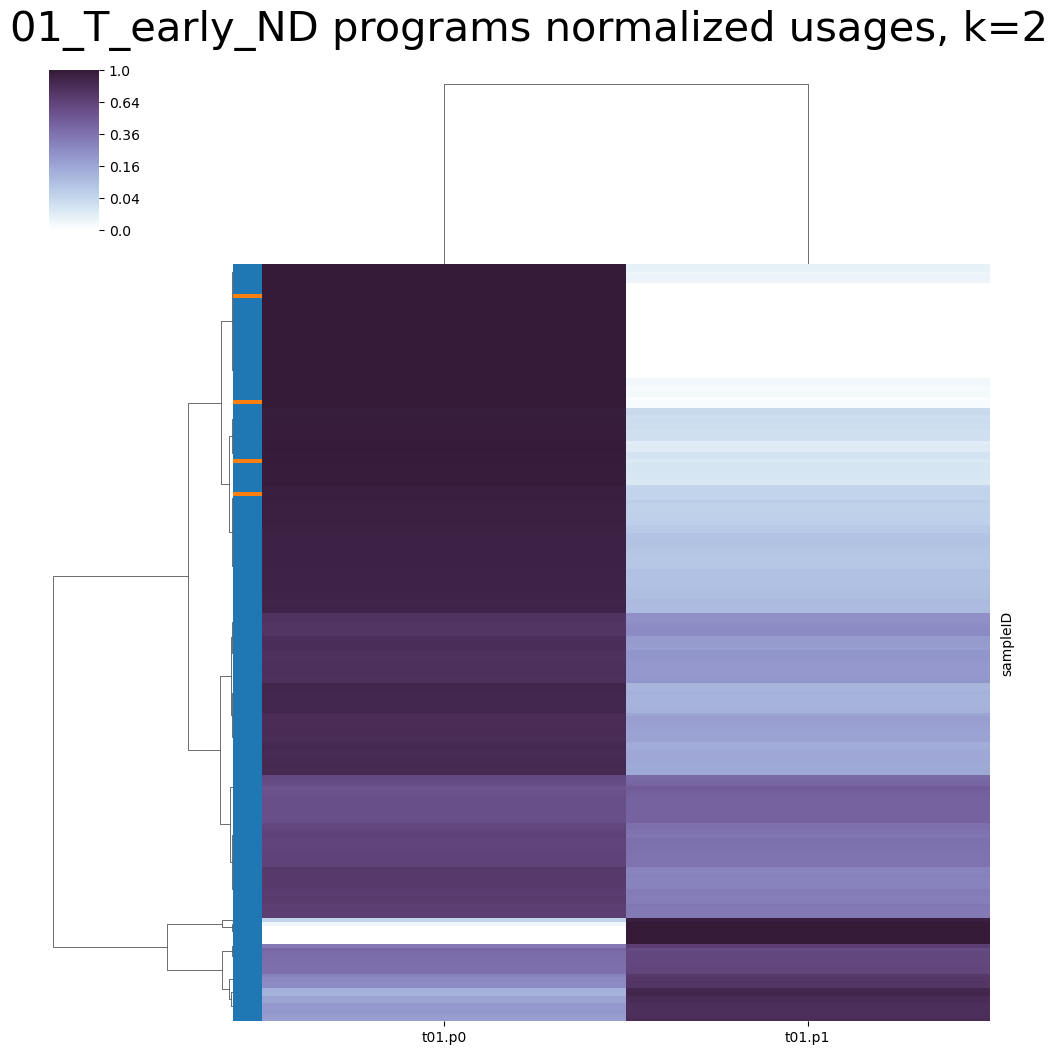

[76.89 23.11]


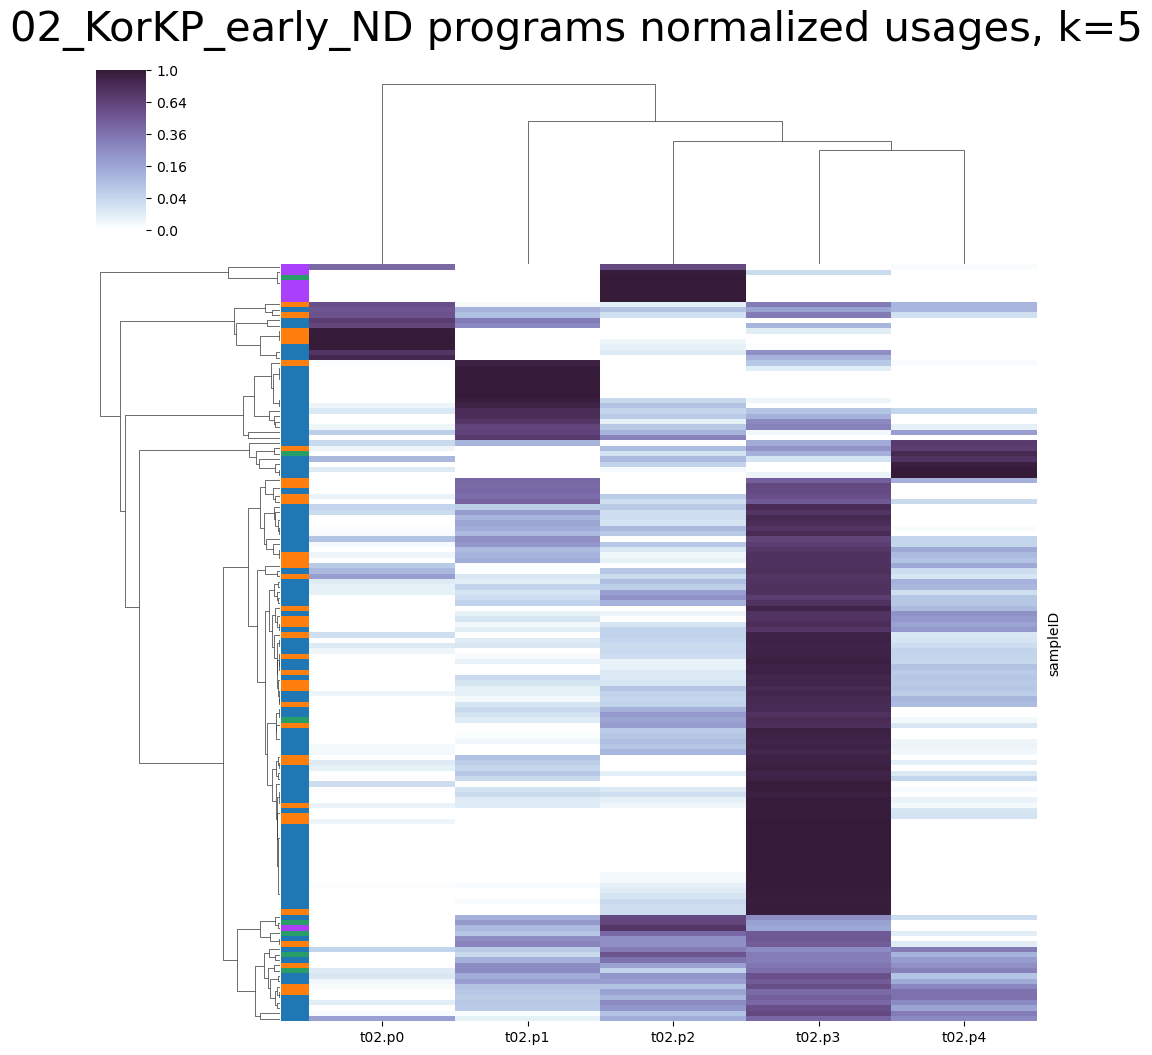

[ 7.09 14.74 11.62 57.44  9.11]


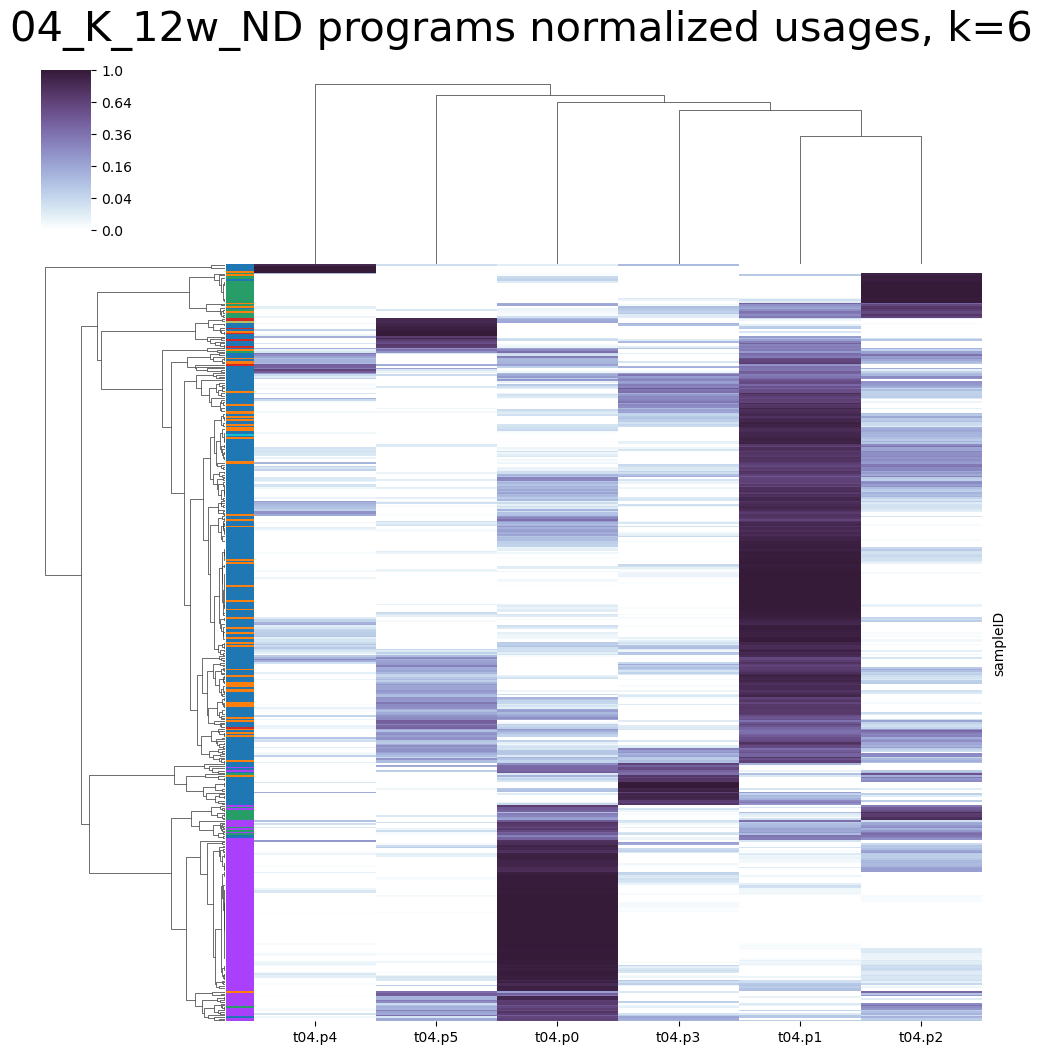

[26.99 43.95 12.16  6.72  2.96  7.21]


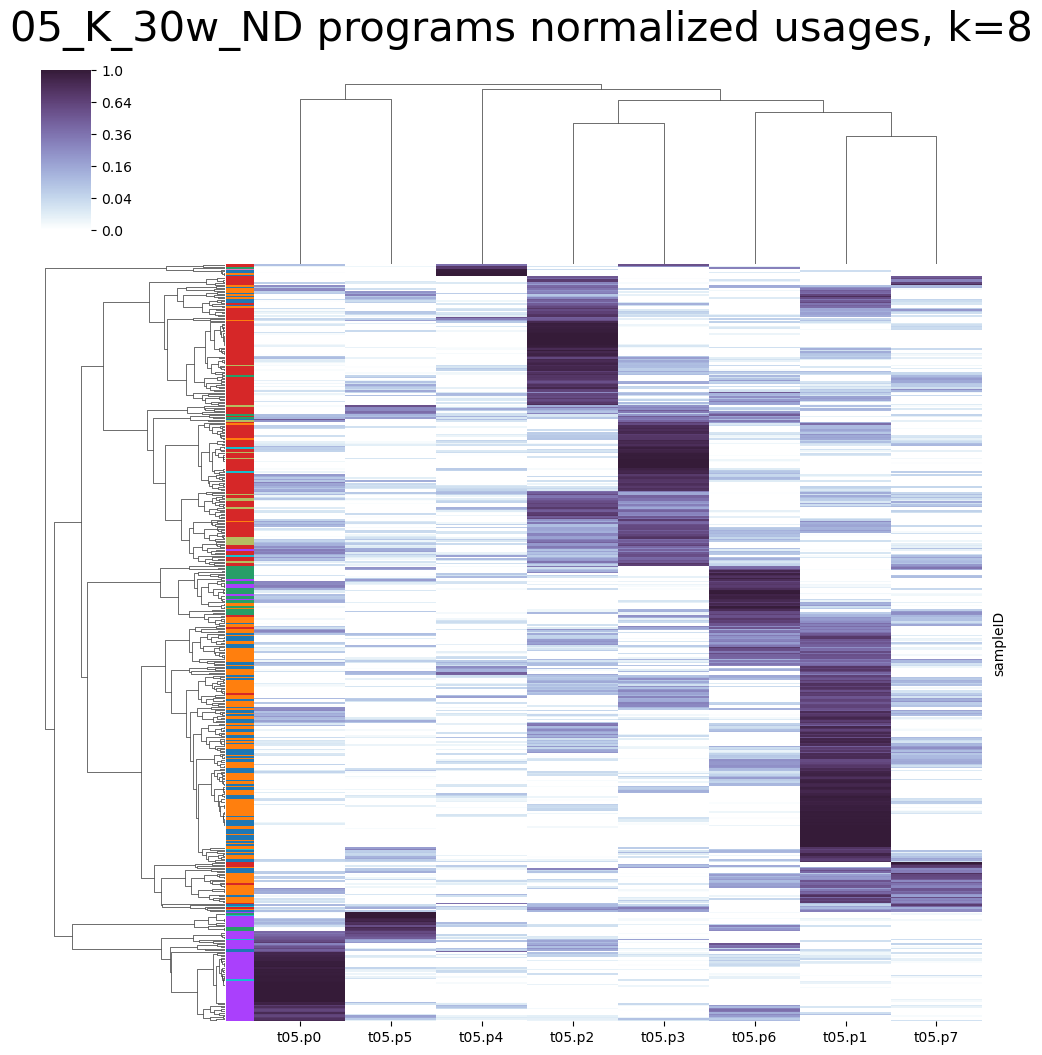

[12.73 28.59 17.71 15.12  3.13  5.02 11.6   6.11]


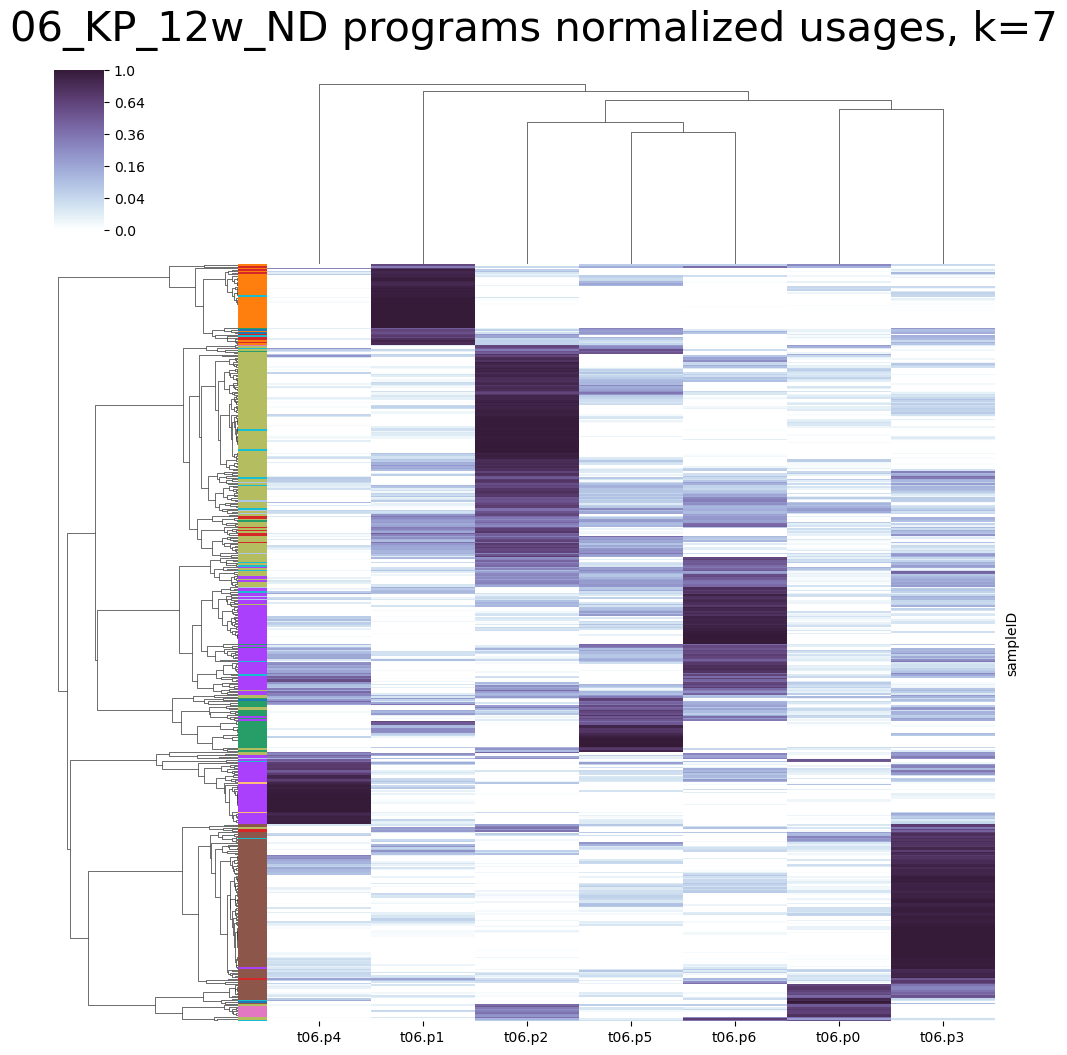

[ 4.69 12.67 24.25 23.21 10.38  9.43 15.35]


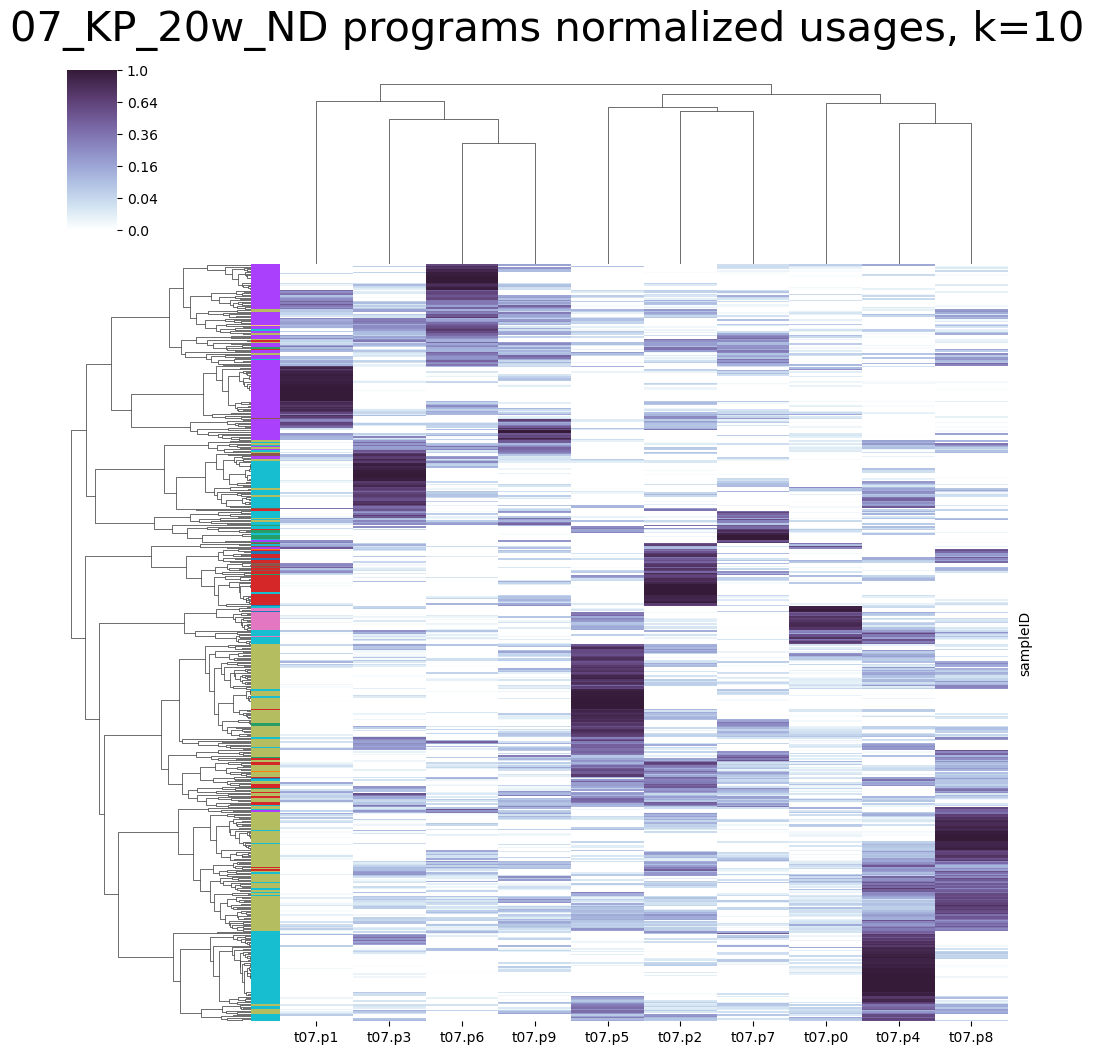

[ 4.85  9.53 11.12 10.23 15.18 14.93  8.76  5.86 13.31  6.25]


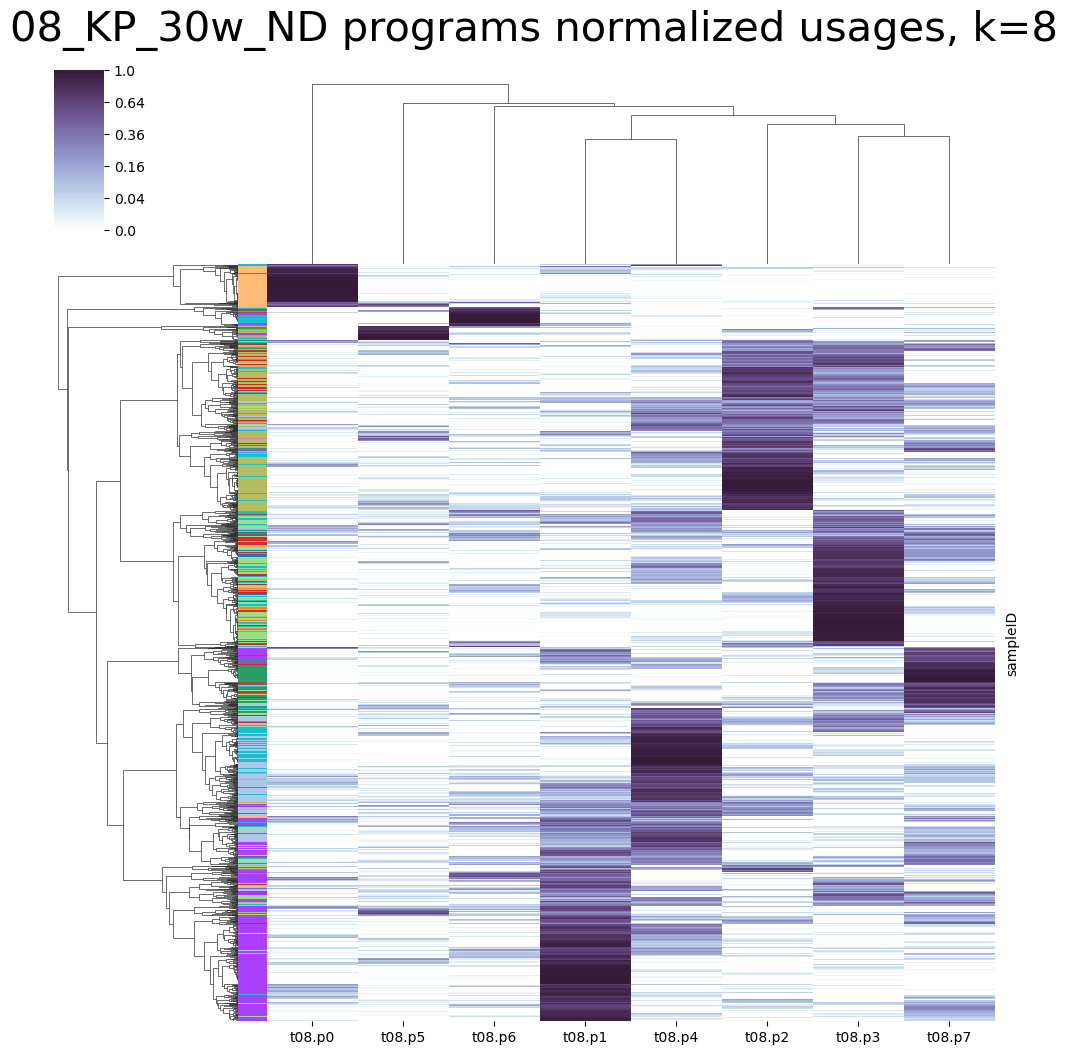

[ 6.56 18.33 15.67 20.06 17.95  4.06  5.32 12.05]


In [555]:
# Plotting normalized usages clustermap
for time in times:
    tmp = split_adatas[time]
    sname = tmp.uns["sname"]
    k = tmp.obsm["usages"].shape[1]

    un_sns = _utils.plot_usages_norm_clustermaps(tmp, show=True)
    un_sns.savefig(results_dir.joinpath(
        sname, f'{sname}.usages_norm.k_{k}.png'),
        dpi=180, bbox_inches='tight')
    plt.close(un_sns.fig)

    _utils.plot_usages_norm_violin(
        tmp, 'clusterK12', save_path=results_dir.joinpath(
            sname, f'{sname}_norm_usage_per_lineage_k_{k}.png'))




## ToDo - plot all programs on phate
## ToDo - consider adding "main program" per cell and plot it on joint tsne and phate

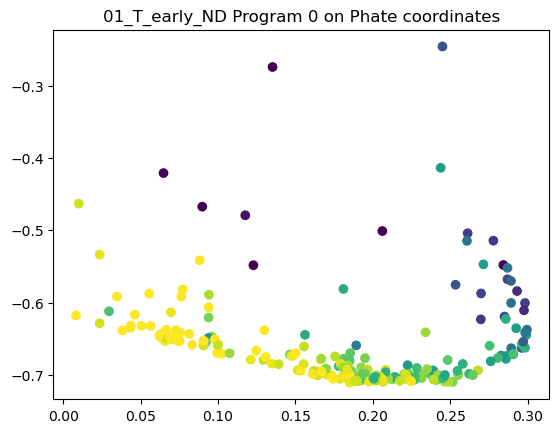

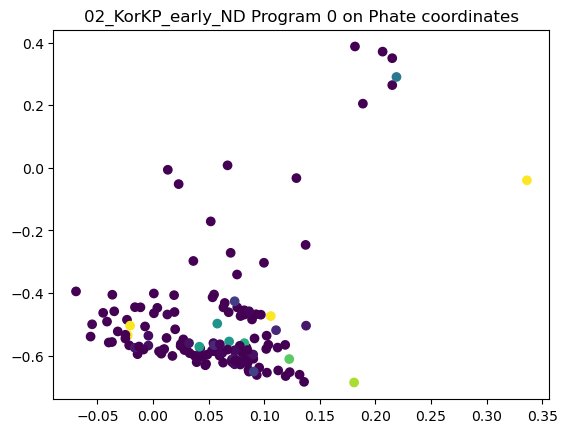

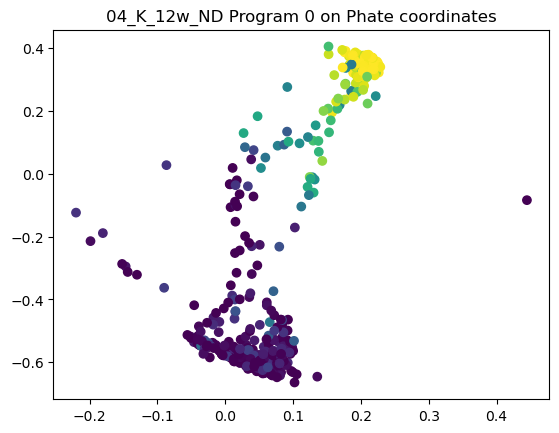

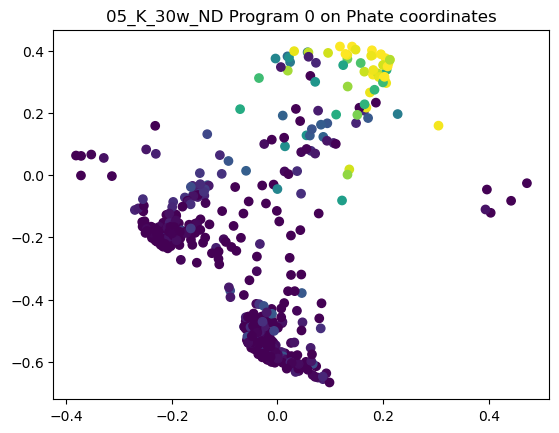

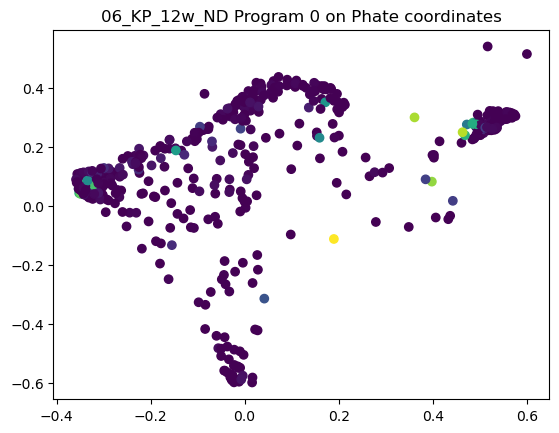

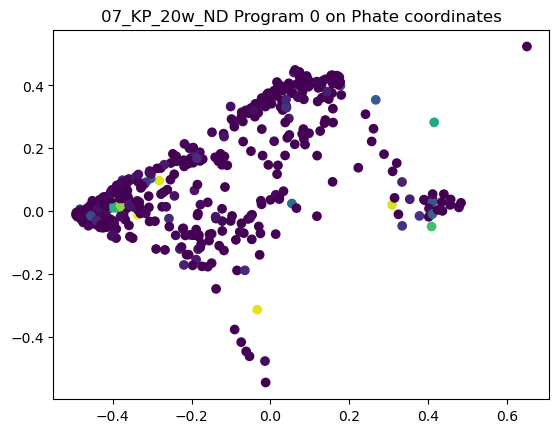

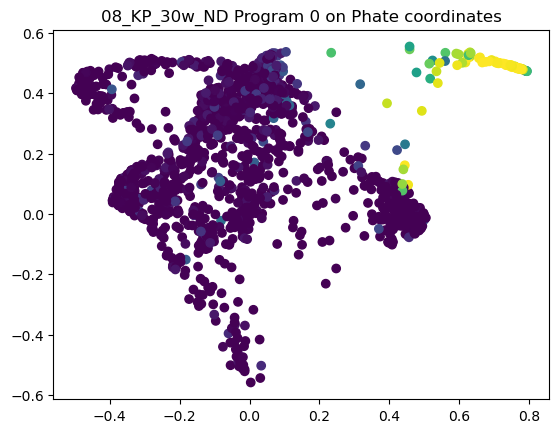

In [556]:
for time in times:
    tmp = split_adatas[time]
    plt.scatter(tmp.obsm['X_phate'][:, 0], tmp.obsm['X_phate'][:, 1], c=tmp.obsm['usages_norm'][:, 0])
    plt.title(f'{tmp.uns["name"]} Program 0 on Phate coordinates')
    plt.show()
    plt.close()

In [ ]:

# sub-setting the genes:
mutual_hvg = list(set().union(*[tmp.var[tmp.var.highly_variable].index \
                          for time, tmp in split_adatas.items()]))
mutual_hvg = list(set(mutual_hvg).intersection(*[tmp.var[tmp.var.highly_variable].index \
                          for time, tmp in split_adatas.items()]))
# mutual_hvg = adata.var[adata.var.highly_variable].index

concatenated_spectras = pd.concat([
    tmp.varm['usage_coefs'].loc[mutual_hvg].copy() for time, tmp in split_adatas.items()], axis=1)

n_genes, n_programs = concatenated_spectras.shape

pearson_corr = np.corrcoef(concatenated_spectras.T)

# cosine figure
fig, ax = plt.subplots(figsize=(4 + n_programs * 0.43, 4 + n_programs * 0.41))

_utils.heatmap_with_numbers(
    pearson_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title('Pearson correlation',
             size=25, y=1.05, x=0.43)

fig.savefig(results_dir.joinpath('correlation_pearson.png'),
            dpi=180, bbox_inches='tight')
plt.close(fig)


# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(pearson_corr[np.triu_indices_from(pearson_corr, k=1)],
         bins=np.linspace(-1, 1, 41))
ax.set_title('Pearson correlation distribution')
plt.show()

fig.savefig(results_dir.joinpath('correlation_histogtam_pearson.png'),
            dpi=180, bbox_inches='tight')

plt.close(fig)

# 3.1b Calculating spearman correlation between usages coefficient

from scipy.stats import rankdata
N_COMPARED_RANKED = 1000

ranked_coefs = n_genes - rankdata(concatenated_spectras, axis=0)

ranked_coefs[ranked_coefs > N_COMPARED_RANKED] = N_COMPARED_RANKED

spearman_corr = np.corrcoef(ranked_coefs, rowvar=False)

# spearman figure
fig, ax = plt.subplots(figsize=(4 + ranked_coefs.shape[1] * 0.43,
                                4 + ranked_coefs.shape[1] * 0.41))

_utils.heatmap_with_numbers(
    spearman_corr, ax=ax, param_dict={'vmin': 0, 'vmax': 1})

ax.xaxis.tick_bottom()
ax.set_xticklabels(concatenated_spectras.columns, rotation='vertical')
ax.set_yticklabels(concatenated_spectras.columns)
ax.set_title(f'{N_COMPARED_RANKED}-Truncated Spearman Correlation',
             size=25, y=1.05, x=0.43)

fig.savefig(results_dir.joinpath(
    f'correlation_spearman_{N_COMPARED_RANKED}_truncated.png'),
    dpi=180, bbox_inches='tight')

plt.close(fig)

# correlation histogram
fig, ax = plt.subplots(figsize=(6, 5))

plt.hist(spearman_corr[np.triu_indices_from(spearman_corr, k=1)],
         bins=np.linspace(0, 1, 21))
ax.set_title('Spearman Correlation distribution')
plt.show()

fig.savefig(results_dir.joinpath(
    f'correlation_histogtam_spearman_{N_COMPARED_RANKED}_truncated.png'),
    dpi=180, bbox_inches='tight')

plt.close(fig)

In [ ]:

import matplotlib as mpl
import networkx as nx
from scipy.cluster import hierarchy

threshold = 0.2

# maping adata short name to layer number
name_map = {}
for i, time in enumerate(times):
    name_map['t'+time[:2]] = i + 1

ks = [tmp.obsm['usages_norm'].shape[1] for time, tmp in split_adatas.items()]

# adjacency matrix creation and filtering

adj_df = pd.DataFrame(np.round((spearman_corr + pearson_corr) / 2, 2),
                      index=concatenated_spectras.columns,
                      columns=concatenated_spectras.columns)

# order
linkage = hierarchy.linkage(
    adj_df, method='average', metric='euclidean')
prog_order = hierarchy.leaves_list(
    hierarchy.optimal_leaf_ordering(linkage, adj_df))

np.fill_diagonal(adj_df.values, 0)
# adj_df.values[adj_df.values <= 0.0] = 0

# keeping only edges between consecutive layers
for i in range(len(ks) - 2):
    adj_df.values[:np.sum(ks[:i + 1]), np.sum(ks[:i + 2]):] = 0
    adj_df.values[np.sum(ks[:i + 2]):, :np.sum(ks[:i + 1])] = 0

adj_df.values[adj_df.values <= threshold] = 0
print(f'Number of edges={np.count_nonzero(adj_df)}')

# ordering the nodes for display
adj_df = adj_df.iloc[prog_order, prog_order]

# create the graph object
G = nx.from_numpy_array(adj_df.values, create_using=nx.Graph)
nx.relabel_nodes(G, lambda i: adj_df.index[i], copy=False)
nx.set_node_attributes(
    G, {node: name_map[node.split('.')[0]] for node in G.nodes}, name='layer')

# prepare graph for display
layout = nx.multipartite_layout(G, subset_key='layer')

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edge_width = 15 * np.power(weights, 2)  # visual edge emphesis

for layer in {data['layer'] for key, data in G.nodes.data()}:
    nodes = [node for node in G.nodes if name_map[node.split('.')[0]] == layer]

    angles = np.linspace(-np.pi / 4, np.pi / 4, len(nodes))

    for i, node in enumerate(nodes):
        layout[node] = [layer + 2 * np.cos(angles[i]), np.sin(angles[i])]

fig, ax = plt.subplots(1, 1, figsize=(16.4, 19.2), dpi=180)
nx.draw(G, layout, node_size=1500, with_labels=False, edge_color=weights,
        edge_vmin=threshold, edge_vmax=1., width=edge_width, ax=ax)

cmp = mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=threshold, vmax=1))
plt.colorbar(cmp, orientation='horizontal', cax=fig.add_subplot(15, 5, 71))

# change color of layers
for time, tmp in split_adatas.items():
    nx.draw_networkx_nodes(
        G, layout, node_color=adata.uns['timesimple_colors_dict'][time],
        node_size=1400, nodelist=[f'{tmp.uns["sname"]}.p{i}' for i in range(
            tmp.obsm['usages'].shape[1])], ax=ax)
nx.draw_networkx_labels(G, layout, font_size=11, ax=ax)

ax.set_title(f'Timepoint correlation graph, correlation threshold={threshold}',
             {'fontsize': 25})
plt.show()


fig.savefig(results_dir.joinpath(
    f'correlations_graph_threshold_{threshold}.png'),
    dpi=180, bbox_inches='tight')

plt.close()

del name_map, G, edges, weights, i, layer, angles, node, nodes
del fig, ax, layout, prog_order